# 37-CpG Signature

## Where the data at?

In [1]:
import pandas as pd
import sys
sys.path.append('../')

mount = '/mnt/e/ALMA/'
input_path = mount + 'Intermediate_Files/'
output_path = mount + 'Processed_Files/'
zhou2016_probes_path =  mount + 'UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv'

## Load data

In [2]:
# read df_discovery and df_test
df = pd.read_pickle(
    input_path+'3314samples_331556cpgs_nobatchcorrection_bvalues.pkl').sort_index()

# Read clinical data
clinical_data = pd.read_excel(input_path+'clinical_data.xlsx', index_col=0)

## Remove samples based on certain clinical features

### Select samples from AAML1031, 0531, and 03P1 clinical trials

In [3]:
clinical_data2 = clinical_data[clinical_data['Clinical Trial'].isin(['AAML0531', 'AAML1031', 'AAML03P1'])]

print(
    f'{clinical_data.shape[0]-clinical_data2.shape[0]} samples were removed. {clinical_data2.shape[0]} samples remaining.')


2262 samples were removed. 1287 samples remaining.


### Select diagnostic samples only

In [4]:
clinical_data3 = clinical_data2[clinical_data2['Sample Type'].isin(
    ['Diagnosis', 'Primary Blood Derived Cancer - Bone Marrow', 'Primary Blood Derived Cancer - Peripheral Blood'])]

print(
    f'{clinical_data2.shape[0]-clinical_data3.shape[0]} samples were removed. {clinical_data3.shape[0]} samples remaining.')

332 samples were removed. 955 samples remaining.


### Remove duplicate samples

In [5]:
clinical_data4 = clinical_data3[~clinical_data3['Patient_ID'].duplicated(keep='last')]

print(
    f'{clinical_data3.shape[0]-clinical_data4.shape[0]} samples were removed. {clinical_data4.shape[0]} samples remaining.')


9 samples were removed. 946 samples remaining.


### Match samples in clinical data to samples in methylation data

In [6]:
# Match samples in clinical data to samples in methylation data
df2 = df[df.index.isin(clinical_data4.index)].iloc[:, 1:]

print('Samples in clinical data matched to samples in methylation data.')

Samples in clinical data matched to samples in methylation data.


## Transform to M-values

In [7]:
import math
import numpy as np

def beta2m(val):
    '''Transfrom beta-values into m-values'''
    return math.log2(val/(1-val))

df3 = df2.apply(np.vectorize(beta2m))

## Perform batch correction

- __pyCombat__ is a Python tool for batch effects correction in high-throughput molecular data using empirical Bayes methods

- __Github__: [https://epigenelabs.github.io/pyComBat/](https://epigenelabs.github.io/pyComBat/)

- __Implementation Preprint__: [bioRxiv](https://doi.org/10.1101/2020.03.17.995431)

- __Original Paper__: [Adjusting batch effects in microarray expression data using empirical Bayes methods](https://pubmed.ncbi.nlm.nih.gov/16632515/)

In [8]:
from combat.pycombat import pycombat

# Correct batch effects in the training dataset
df4 = pycombat(data = df3.T, batch = df[df.index.isin(df3.index)].iloc[:, 0]).round(3).T

print('Succesfully corrected batch effects in the training dataset.')


Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Succesfully corrected batch effects in the training dataset.


### Evaluate batch effects

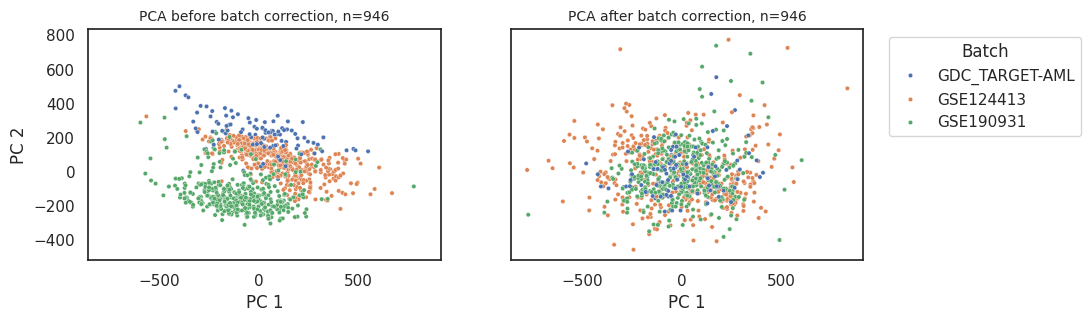

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='white')

def standardize_data(df):
    '''Standardizes the data.'''
    return StandardScaler().fit_transform(df.T)

def perform_pca(std_data):
    '''Performs PCA on standardized data.'''
    pca = PCA(n_components=2, random_state=42)
    return pca.fit_transform(std_data)

def create_principal_df(pca_data, df4 , df):
    '''Creates a DataFrame with the PCA data.'''
    principal_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'], index=df4.columns)
    principal_df['hue'] = df[df.index.isin(df3.index)].iloc[:, 0]
    return principal_df

def filter_df(df, principal_df, threshold):
    '''Filters the DataFrame by removing outliers.'''
    outliers = principal_df[principal_df['PC1'] >= threshold].index
    return df.drop(outliers, axis=1)

X_std = standardize_data(df4.T)
principal_components = perform_pca(X_std)
pcs_batchcorrected = create_principal_df(principal_components, df4.T, df)

X_std = standardize_data(df3.T)
principal_components = perform_pca(X_std)
pcs_uncorrected = create_principal_df(principal_components, df3.T, df)

def plot_data(principal_df, non_outliers):
    '''Plots PCA data.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
    
    for df, ax, title, legend in [(principal_df, ax2,
                                   'PCA after batch correction, n=' + str(principal_df.shape[0]), 'full'),
                                  (non_outliers, ax1,
                                   'PCA before batch correction, n=' + str(non_outliers.shape[0]), False)]:
        sns.scatterplot(data=df, x='PC1', y='PC2', hue='hue', s=10, alpha=1, ax=ax, legend=legend)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Batch')
    plt.show()

plot_data(pcs_batchcorrected, pcs_uncorrected)


```{note}
1. GDC_TARGET-AML contains AAML0531 and 03P1 samples from methylation array 450k.
2. GSE124413 contains AAML0531 and 03P1 samples from methylation array EPIC.
3. GSE190931 contains AAML1031 samples from methylation array EPIC.
```

## Run CoxPH-EWAS

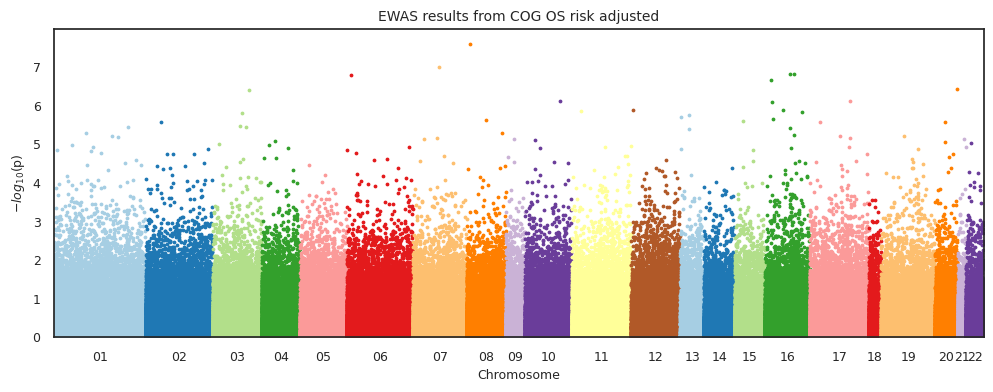

In [10]:
from utils.methylize_custom_code.diff_meth_pos_custom import *

# def impute_by_mean(df):
#     return df.fillna(df.mean())

# covar_os = round(impute_by_mean(clinical_data4[['os.evnt at 5y','os.time at 5y','Risk_Group_AAML1831_int']]),3)

# ewas_os_cog_adjusted = diff_meth_pos(meth_data = df4,
#                                     duration = covar_os['os.time at 5y'],
#                                     event_observed = covar_os['os.evnt at 5y'],
#                                     pheno_data = covar_os['os.time at 5y'], # not used
#                                     covariates = covar_os['Risk_Group_AAML1831_int'],
#                                     regression_method = "coxph",
#                                     export = 'pkl',
#                                     verbose = False,
#                                     filename=output_path + 'ewas_dmr/ewas_cog_os_batch_corrected_risk_adjusted')

ewas_os_cog_adjusted = pd.read_pickle(output_path + 'ewas_dmr/ewas_cog_os_batch_corrected_risk_adjusted.pkl')

manhattan_plot(stats_results=ewas_os_cog_adjusted,
                        palette='Paired',
                        save=False,
                        suggestive=True,
                        significant= False,
                        width=12,
                        height=4,
                        statsmode=False,
                        bonferroni=False,
                        fontsize=9,
                        array_type='450k',
                        explore=False,
                        border = True,
                        label_sig_probes=False,
                        fwer=0.05,
                        cohorts= " COG OS risk adjusted",
                        filename='../Figures/Manhattan_Plots/ewas_os_unadjusted')

## Select CpGs based on suggested-significance p-values (1*10e-5)

In [11]:
# Select only rows where `PValue`< 1*10e-5
ewas_os_cog_adjusted_sig = ewas_os_cog_adjusted[ewas_os_cog_adjusted['PValue'] < 1*10e-5]

# Define a function to handle repetitive tasks
def process_df(df, other_df, column_drop):
    # Join and sort values
    df = df.join(other_df.drop(columns=column_drop), how='inner').sort_values(by='PValue')

    # Handle columns with multiple genes separated by `;`
    for col in ['GeneNames', 'GeneClasses']:
        df[col] = df[col].apply(lambda x: ';'.join(set(x.split(';'))))

    return df

# Load manifest
zhou2016_probes = pd.read_csv(zhou2016_probes_path,
                              sep='\t',index_col=0)[['chrm','start', 'end', 'GeneNames',
                                                     'GeneClasses','CGIPosition']]

# Get probes from Zhou et al. (2016) that are in ewasOS_un.index
top_os = process_df(zhou2016_probes, ewas_os_cog_adjusted_sig, ['chromosome', 'MAPINFO'])

# Now include the date in the filename and save to excel
# import datetime
# top_os.to_excel(output_path + 'ewas_dmr/ewas_stats_' + str(datetime.date.today()) + '.xlsx')

# Select only significant probes
ewas_top_cpgs_os = df4[top_os.index.to_list()]

# Save x to pickle in output_path
ewas_top_cpgs_os.to_csv(output_path + 'ewas_dmr/ewas_top_cpgs_os'+ str(datetime.date.today())+ '.csv')

from itables import show

show(top_os, classes="display nowrap compact",  style="width:1500px", autoWidth=False)

## Train CoxPH+Lasso model with the selected CpGs

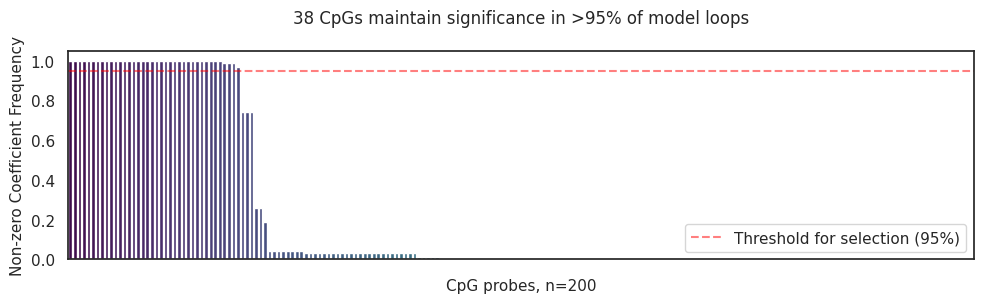

In [22]:
from utils.cox_lasso import *

# raw_coefs = train_coxph_lasso(df=clinical_data4.copy(),
#                                 event= 'os.evnt at 5y',
#                                 time= 'os.time at 5y',
#                                 train_x=ewas_top_cpgs_os,
#                                 cv_n_split=10,
#                                 loops=100)
# raw_coefs.to_csv(output_path + 'ewas_dmr/ewas_cog_os_raw_coefs_newrisk.csv')


raw_coefs = pd.read_csv(output_path + 'ewas_dmr/ewas_cog_os_raw_coefs_newrisk.csv', index_col=0)

mean_coefs = set_cutoff(coefs=raw_coefs,threshold=0.95)
                                
plot_nonzero_coef_freq(raw_coefs, mean_coefs, threshold=0.95, savefig=False, fig_path=None, figsize=(10,3.2))

## Apply signature to discovery dataset and set high/low cutoff

Continuous score cut at the value of -2.0263


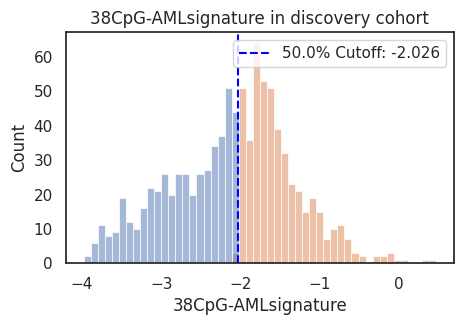

In [23]:
score_name = '38CpG-AMLsignature'
CUTOFF = 0.5


df5, threshold = generate_coxph_score(coef_mean=mean_coefs,
                                        x=ewas_top_cpgs_os,
                                        df=clinical_data4,
                                        score_name=score_name,
                                        cutoff='quantile',
                                        cutoff_value=CUTOFF)

# df.to_excel(output_path + 'multivariate_cox_lasso/ewas_cog_os_MethylScoreAML_Px.xlsx')

# Plot results

plt.figure(figsize=(5, 3))
sns.histplot(data=df5, x=score_name, bins=50, hue = score_name + ' Categorical' )
plt.axvline(threshold ,color='blue', linestyle='--')
plt.legend({f'{CUTOFF*100}% Cutoff: ' + str(threshold.round(3)):threshold})
plt.title(score_name + ' in discovery cohort')
plt.show()

## Apply signature to validation dataset

Continuous score cut at the value of -2.0263


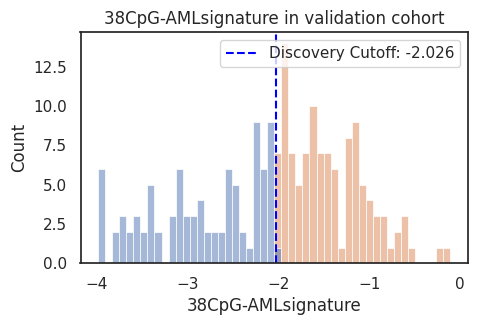

In [25]:
# Load test data and pick only columns that are in mean_coefs
df_test = pd.read_pickle(
    input_path+'201samples_331556cpgs_nobatchcorrection_bvalues.pkl').sort_index()[mean_coefs.index]

# Transform from beta-values to m-values
df_test2 = df_test.apply(np.vectorize(beta2m))

# Select samples from `clincal_data` that are in `df_test`
clinical_data_test = clinical_data[clinical_data.index.isin(df_test.index)]

# apply signature to test data using `threshold` from training data
clinical_data_test2 , _ = generate_coxph_score(coef_mean=mean_coefs,
                                        x=df_test2,
                                        df=clinical_data_test,
                                        score_name=score_name,
                                        cutoff=threshold)

# Plot the results
plt.figure(figsize=(5, 3))
sns.histplot(data=clinical_data_test2, x=score_name, bins=50, hue = score_name + ' Categorical')
plt.axvline(threshold ,color='blue', linestyle='--')
plt.legend({'Discovery Cutoff: ' + str(threshold.round(3)):threshold})
plt.title(score_name + ' in validation cohort')
plt.show()

## Merge and save files

In [27]:
final_df = pd.concat([clinical_data_test2, clinical_data4], axis=0)

final_df.iloc[:,-3:].to_excel('../data/signature_results.xlsx')

## Watermark

In [28]:
%load_ext watermark

In [29]:
%watermark -v -p methylize,pandas -a Francisco_Marchi@Lamba_Lab_UF -d -m -r -u

Author: Francisco_Marchi@Lamba_Lab_UF

Last updated: 2024-09-14

Python implementation: CPython
Python version       : 3.8.18
IPython version      : 8.12.3

methylize: not installed
pandas   : 2.0.3

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Git repo: git@github.com:f-marchi/ALMA.git

